# Data Analytics Final Project: 
*"Comparing Researchers teaching performance with faculty members dedicated completely to teaching"*

- Luis Ángel Sedas Díaz
- Mario Chávez

Tecnológico de Monterrey, Monterrey, NL, México

<p style="background-color:rgb(230,230,230);"> <b>Abstract:</b> University rankings have become a relevant factor that measures quality and performance. In those rankings, research activity is one of the most important metrics, and so universities need to motivate their faculty members to constantly contribute with new knowledge. It is common for researchers to also do lectures at different academic levels, apart from their research activity. The background and activities of a researcher are different from someone who is fully dedicated to teaching. For many years, there has been a debate between who usually develops better as a teacher, whether researchers or full-time professors. The current research aims to end with that discussion. The stated hypothesis is that researchers teaching performance is better than faculty members dedicated completely to teaching. The results of this analysis could be of significant relevance to academic institutes and could support the development of efficient research and learning strategies.</p>

## Contents
1. [Data Wrangling](DA-cleaning.ipynb) - Notebook for cleaning data
2. [Functions](functions.ipynb) - all created functions
3. [Descriptive Analysis](#descriptive_analysis)
    1. [Pie Charta](#pie_charts)
    2. [Score Distributions](#score_distributions)
4. [Feature Selection](#feature_selection)
5. [Clustering](#clustering.ipynb)
6. [Classification](#classification.ipynb)
7. [Conclusions](#conclusions)


Questions and Tasks:
- What is the relation between research and teaching?
- What characteristics do researchers, who are qualified as good/bad, have in common?
- What characteristics do professors, who are qualified as good/bad, have in common?
- Create a classification variable (good or bad) for each professor, and so we need to generate a criteria of what is a good/bad score. We can start by partition around the median (50%).
- Find which variables affect the most the score in ECOA (feature selection).
- Apply clustering to find similarities between individuals.

<p style="background-color:yellow;"> We want to test if a category makes a significant difference in the scores distribution. With this we can generate a set of features later on in the clustering phase. We also need to research feature selection and the preprocessing package of scikitlearn to understand the best way to prepare the data.</p>

## 1. Data Wrangling
The data is an `.xlsx` file, with 15781 registers and 60 feautures, that describe the course, the professor and the evaluation of students.

In [1]:
%run .\DA-cleaning.ipynb

## 2. Functions

In [2]:
%run .\functions.ipynb

## 3. Descriptive Analysis<a id='descriptive_analysis'></a>
Here I try to understand how the data is distributed along the different features 

In [3]:
# Creates a table, grouping by 'Campus'
table_count_campus = data[['campus','ID']].groupby(['campus'],as_index=False).count().sort_values(by=['ID'],ascending=False).reset_index(drop=True)
table_count_campus['percentage'] = table_count_campus['ID']/len(data)*100

In [4]:
# Creates a new table, groping the last 24 campus as 'Others'
new_table_count_campus = table_count_campus[0:8].copy()

d = {'campus': ['Others'], 'ID': [table_count_campus[7:].ID.sum()], 'percentage': [table_count_campus[8:].ID.sum()/len(data)*100]}
df = pd.DataFrame(data=d)

new_table_count_campus = new_table_count_campus.append(df, ignore_index=True)

### 3.1 Pie Charts <a id ='pie_charts'></a>

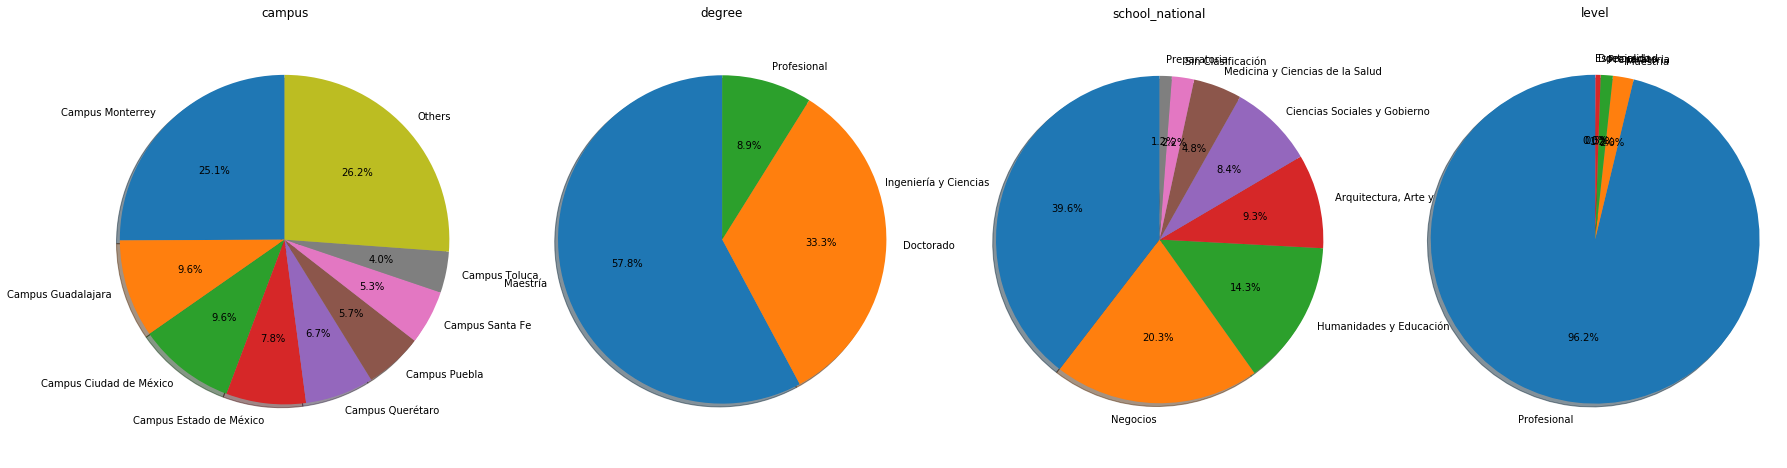

In [5]:
plt.figure(figsize=(30,8))       # set dimensions of the figure
plt.subplot(1,4, 1); pie_plot(new_table_count_campus,'campus','ID')
plt.subplot(1,4, 2); pie_plot(grouping_df(data,'degree','ID'),'degree','ID')
plt.subplot(1,4, 3); pie_plot(grouping_df(data,'school_national','ID'),'school_national','ID')
plt.subplot(1,4, 4); pie_plot(grouping_df(data,'level','ID'),'level','ID')
plt.show()

### 3.2 Score distributions<a id='score_distributions'></a>
Plots the shape of a distribution. Like an histogram, the KDE plots encode the density of observations on one axis with heigth along the other axis.

Drawing a KDE is more computationally involved than drawing a histogram. What happens is that each observation is first replaced with a normal (Gaussian) curve centered at that value.

Next, these curves are summed to compute the value of the density at each point in the support grid. The resulting curve is then normalized so that the area under it is equal to 1.

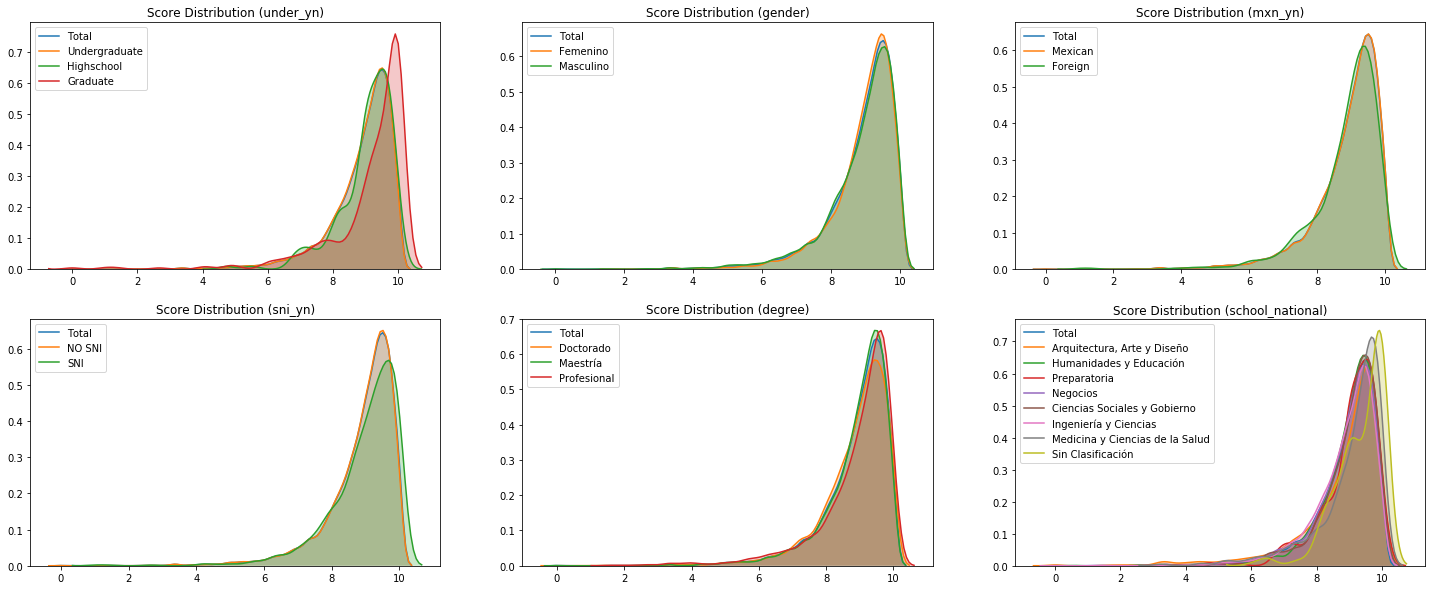

In [27]:
plt.figure(figsize=(25,10))       # set dimensions of the figure
plt.subplot(2,3, 1);     distribution_plot(data,'under_yn')
plt.subplot(2,3, 2);     distribution_plot(data,'gender')
plt.subplot(2,3, 3);     distribution_plot(data,'mxn_yn')
plt.subplot(2,3, 4);     distribution_plot(data,'sni_yn')
plt.subplot(2,3, 5);     distribution_plot(data,'degree')
plt.subplot(2,3, 6);     distribution_plot(data,'school_national')
plt.show()

We can see that Graduate students give better scores to their professors. Because 94% of the data is from undergraduate courses, this distribution is basically the same as the one from the complete data. This also happens in the distribution of "NO SNI" which are the no reseachers, because this represents the 90% of the individuals.

From these plots we can se that the distributions that differ from the rest are the ones of:
- **under_yn**
- **sni_yn**

In [37]:
prueba_pivot = pd.pivot_table(data, values='ID', index=['sni_yn'], columns=['under_yn'], aggfunc=len, margins=True)
(prueba_pivot/15781*100).round(decimals=2)

under_yn,Graduate,Highschool,Undergraduate,All
sni_yn,,,,
NO SNI,1.30,1.12,87.87,90.29
SNI,4.22,0.04,5.44,9.71
All,5.52,1.17,93.31,100.00


From this pivot table we can see different things:
1. Not researchers (NO_SNI) give classes maninly on the Undergraduate level (97.3%)
2. Researchers give (SNI) are divided pretty equally on Undergraduate and Graduate courses (56.02% & 43.4%)

We are going to analyze how researchers and non-researchers behave in:
- General (Along all courses).
- by course level.
- by subject area.

### 3.3 Experience vs Score  <a id='under_grad'></a>

In [3]:
df_under = data[data.under_yn == 'Undergraduate'][['experience','antiguedad','score']].dropna().reset_index(drop=True)
df_grad = data[data.under_yn == 'Graduate'][['experience','antiguedad','score']].dropna().reset_index(drop=True)

df_sni = data[data.sni_yn=='SNI'][['experience','antiguedad','score']].dropna().reset_index(drop=True)
df_nosni = data[data.sni_yn=='NO SNI'][['experience','antiguedad','score']].dropna().reset_index(drop=True)

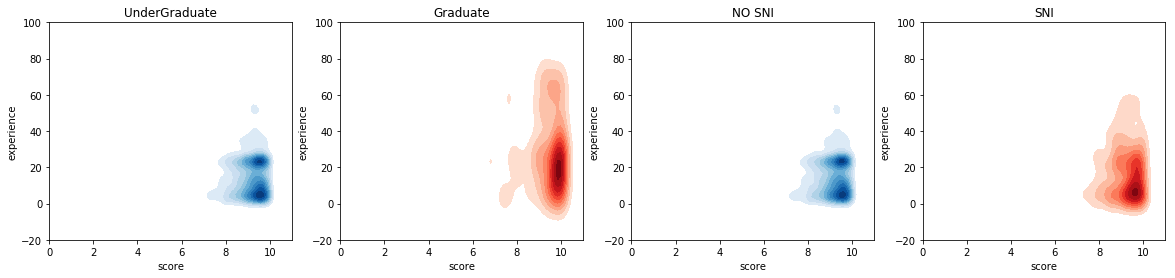

In [4]:
plt.figure(figsize=(20,4))       # set dimensions of the figure

plt.subplot(1,4, 1); 
sns.kdeplot(df_under.score, df_under.experience, cmap="Blues", shade=True, shade_lowest=False)
plt.title('UnderGraduate')
plt.xlim((0,11)); plt.ylim((-20,100))

plt.subplot(1,4, 2); 
sns.kdeplot(df_grad.score, df_grad.experience, cmap="Reds", shade=True, shade_lowest=False)
plt.xlim((0,11)); plt.ylim((-20,100))
plt.title('Graduate')

plt.subplot(1,4, 3); 
sns.kdeplot(df_nosni.score, df_nosni.experience, cmap="Blues", shade=True, shade_lowest=False)
plt.xlim((0,11)); plt.ylim((-20,100))
plt.title('NO SNI')

plt.subplot(1,4, 4); 
sns.kdeplot(df_sni.score, df_sni.experience, cmap="Reds", shade=True, shade_lowest=False)
plt.xlim((0,11)); plt.ylim((-20,100))
plt.title('SNI')

plt.show()

From the Graduate Jointplot we can see that the scores are concentrated and the experience is really spread, so at the graduate level the professors get the same score, but their experience varies a lot. While in the undergraduate case both are relatively spread, bu the experience variable has a bimodal distribution. 


### 3.4 Antiguedad vs Score

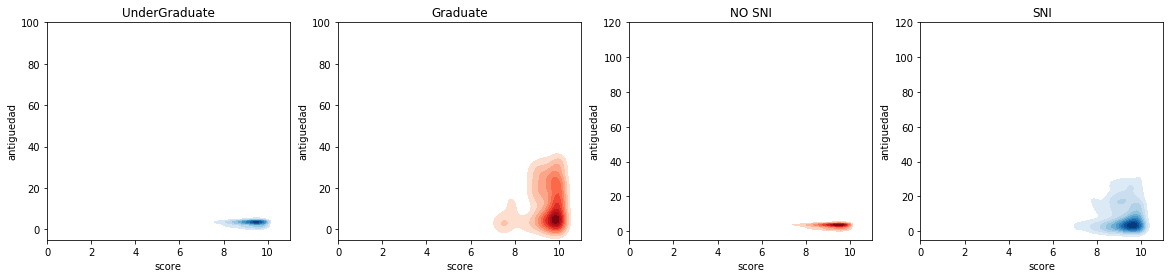

In [105]:
plt.figure(figsize=(20,4))       # set dimensions of the figure

plt.subplot(1,4, 1); 
sns.kdeplot(df_under.score, df_under.antiguedad, cmap="Blues", shade=True, shade_lowest=False)
plt.title('UnderGraduate')
plt.xlim((0,11)); plt.ylim((-5,100))

plt.subplot(1,4, 2); 
sns.kdeplot(df_grad.score, df_grad.antiguedad, cmap="Reds", shade=True, shade_lowest=False)
plt.xlim((0,11)); plt.ylim((-5,100))
plt.title('Graduate')

plt.subplot(1,4, 3); 
sns.kdeplot(df_nosni.score, df_nosni.antiguedad, cmap='Reds',shade=True, shade_lowest=False)
plt.xlim((0,11)); plt.ylim((-5,120))
plt.title('NO SNI')

plt.subplot(1,4, 4); 
sns.kdeplot(df_sni.score, df_sni.antiguedad, cmap='Blues',shade=True, shade_lowest=False)
plt.xlim((0,11)); plt.ylim((-5,120))
plt.title('SNI')

plt.show()

## 4. Feature Selection<a id='feature_selection'></a>

In [106]:
data.columns

Index(['Crn', 'ID', 'rectoria', 'campus', 'division', 'department', 'num_grup',
       'cat_lab', 'cat_escolar', 'cat_rh', 'nationality', 'gender', 'age',
       'antiguedad', 'degree', 'pdhd', 'experience', 'school_national',
       'school_giee', 'giee', 'giee_role', 'SNI', 'percentage_responsability',
       'level', 'terminal_group', 'course_attributes', 'multicampus',
       'main_professor', 'seniors', 'opinions', 'participation', 'teach_hours',
       'lecture_hours', 'lab_hours', 'credits', '05num', '05avg', '05std',
       '06num', '06avg', '06std', '08num', '08avg', '08std', 'books',
       'bseries', 'proceedings', 'journal_q1q2', 'journal_q3q4', 'total',
       'books_norm', 'bseries_norm', 'proceedings_norm', 'journal_q1q2_norm',
       'journal_q1q2_norm', 'total_norm', 'sni_yn', 'score', 'under_yn',
       'counts_total', 'counts_graduate', 'counts_undergraduate',
       'counts_highschool', 'mxn_yn'],
      dtype='object')

In [107]:
data_prep = data[['age', 'antiguedad','experience','percentage_responsability','terminal_group','multicampus','main_professor','seniors','participation','teach_hours',
                  'lecture_hours', 'lab_hours','credits','total_norm', 'sni_yn', 'score','under_yn', 'mxn_yn']];
df_dum = pd.get_dummies(data_prep);

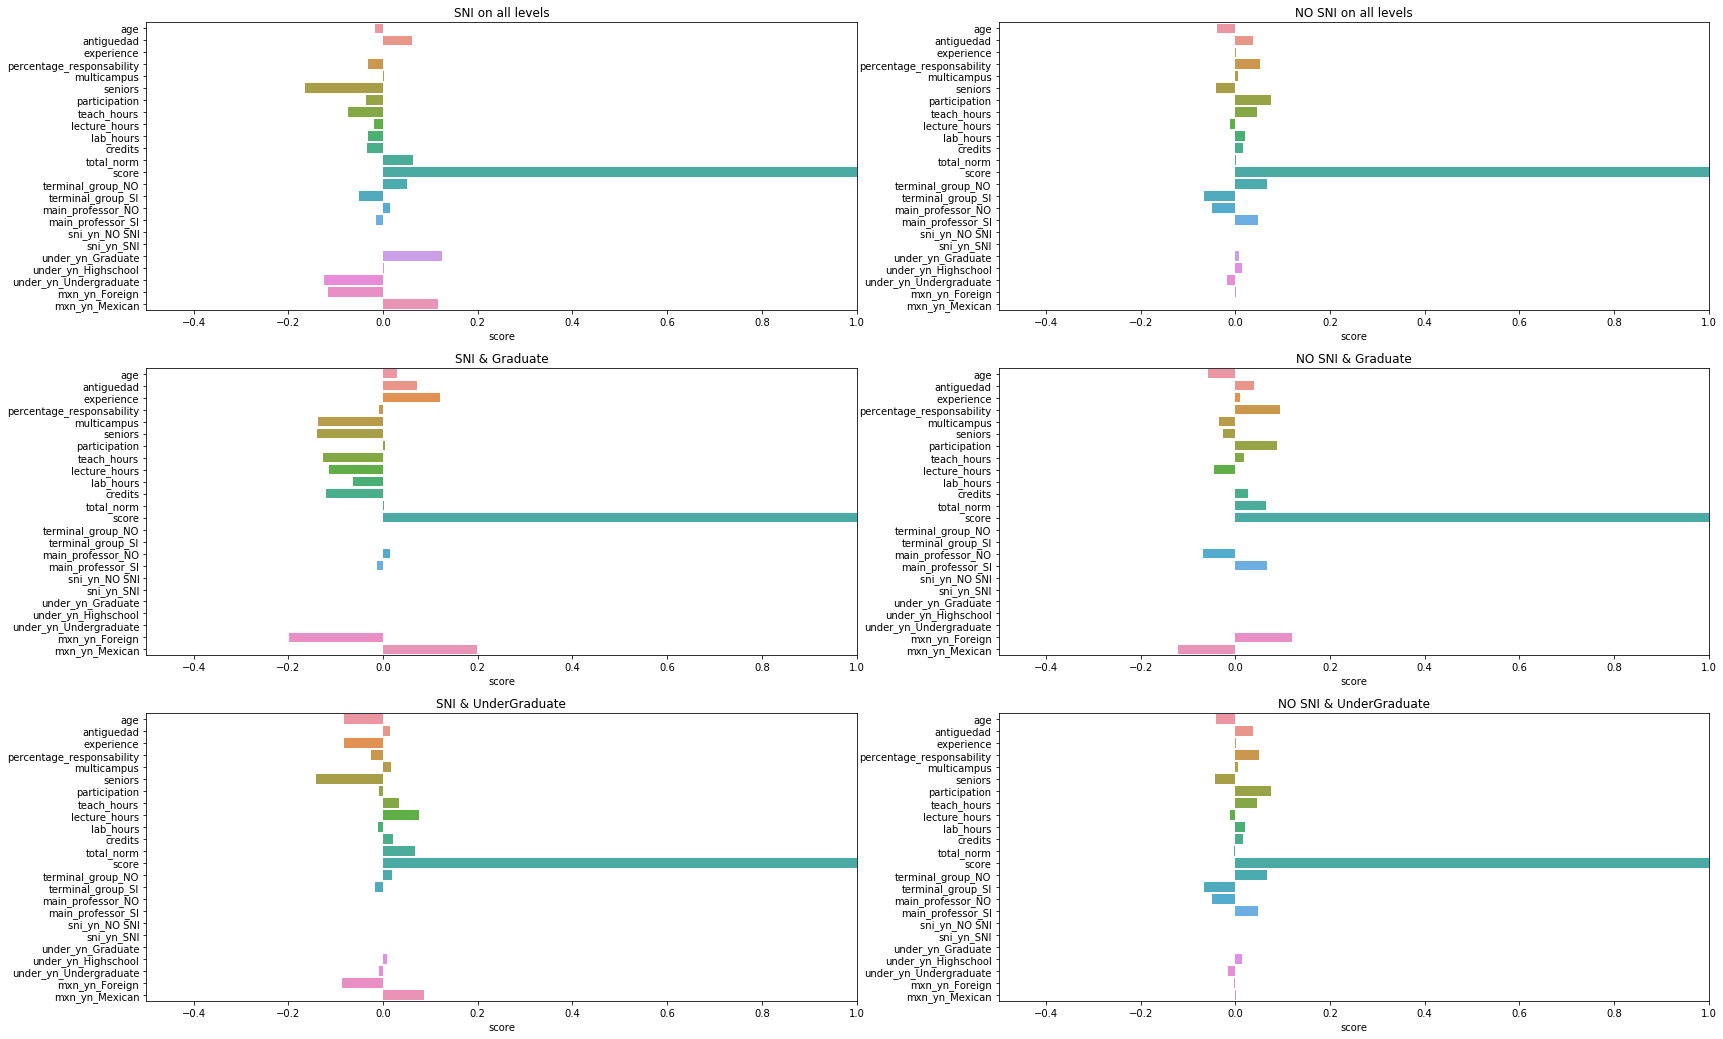

In [108]:
plt.figure(figsize=(28,18))       # set dimensions of the figure

plt.subplot(3,2, 1); 
corr = df_dum[df_dum.sni_yn_SNI==1].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('SNI on all levels')

plt.subplot(3,2, 2); 
corr = df_dum[df_dum.sni_yn_SNI==0].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('NO SNI on all levels')

plt.subplot(3,2, 3); 
corr = df_dum[np.logical_and(df_dum.sni_yn_SNI==1,df_dum.under_yn_Graduate==1)].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('SNI & Graduate')

plt.subplot(3,2, 4); 
corr = df_dum[np.logical_and(df_dum.sni_yn_SNI==0,df_dum.under_yn_Graduate==1)].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('NO SNI & Graduate')

plt.subplot(3,2, 5); 
corr = df_dum[np.logical_and(df_dum.sni_yn_SNI==1,df_dum.under_yn_Graduate==0)].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('SNI & UnderGraduate')

plt.subplot(3,2, 6); 
corr = df_dum[np.logical_and(df_dum.sni_yn_SNI==0,df_dum.under_yn_Graduate==0)].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('NO SNI & UnderGraduate')

plt.show()

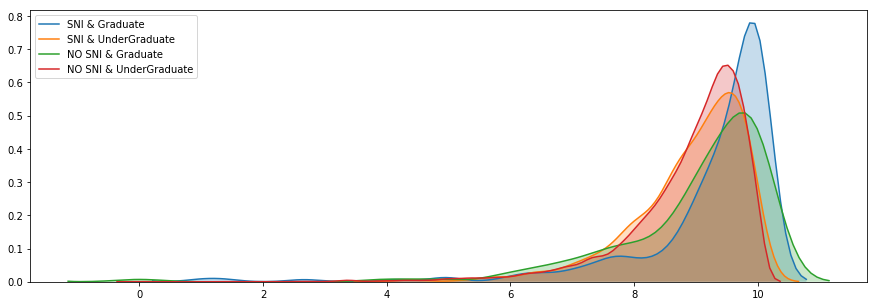

In [110]:
plt.figure(figsize=(15,5))
sns.kdeplot(data[np.logical_and(data.sni_yn=='SNI',data.under_yn=='Graduate')].score, label = 'SNI & Graduate', shade=True)
sns.kdeplot(data[np.logical_and(data.sni_yn=='SNI',data.under_yn=='Undergraduate')].score, label = 'SNI & UnderGraduate', shade=True)
sns.kdeplot(data[np.logical_and(data.sni_yn=='NO SNI',data.under_yn=='Graduate')].score, label = 'NO SNI & Graduate', shade=True)
sns.kdeplot(data[np.logical_and(data.sni_yn=='NO SNI',data.under_yn=='Undergraduate')].score, label = 'NO SNI & UnderGraduate', shade=True)
plt.show()

## 7. Conclusions <a id='conclusions'></a>

# Preguntas
- Qué es bueno? quartiles?
- Error en %Participación, >100% y por lo tanto tambien está mal Alumnos que Opinaron
- Semestres de Experiencia tiene un máximo de 114 
- Mejor variable de experiencia? Semestres de experiencia, edad al semestre, años de antiguedad